In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

import yaml

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Distgen

In [2]:
from pmd_beamphysics import ParticleGroup
from distgen import Generator

DISTGEN_FILE_STR="""
n_particle: 20000
random_type: hammersley
start:
  tstart:
    units: sec
    value: 0
  type: time
total_charge:
  units: nC
  value: 1
r_dist:
  sigma_xy:
    units: mm
    value: 1.0
  type: radial_gaussian
z_dist:
  avg_z:
    units: mm
    value: 0
  sigma_z:
    units: mm
    value: 0.1
  type: gaussian
transforms:
  t1:
    avg_pz: 
      value: 10
      units: MeV/c
    type: set_avg pz
"""

gen = Generator(DISTGEN_FILE_STR,verbose=False)
gen.run()

# Run GPT

In [3]:
from gpt import GPT
from gpt.template import basic_template

drift = 1

settings = {
    'space_charge': 1,
    'Alpha': 1.0,
    'Fn':  0.1,
    'verror':  0.005,
    'Nstd':  12,
    'Ntout': 500,
    'tmax': 1.8*drift/3e8,
    'ZSTOP':drift
}

G = GPT(input_file=basic_template(), initial_particles=gen.particles)
G.set_variables(settings)
G.run()

tout z-pos: 0.991617095377899


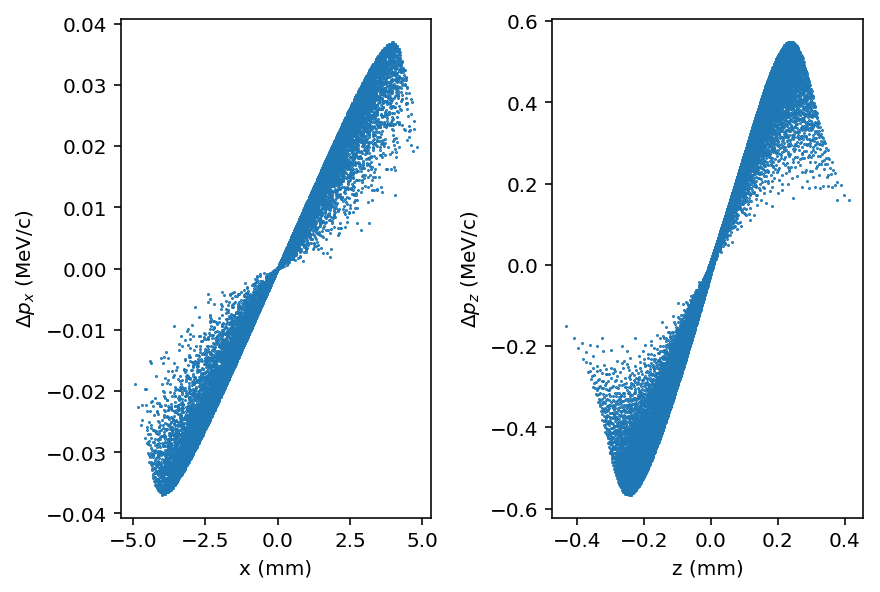

In [4]:
import numpy as np

fig, ax = plt.subplots(1,2, constrained_layout=True)

Pf = G.tout[-3]
print('tout z-pos:',np.mean(Pf['z']))

ax[0].plot(Pf['x']*1000, Pf['delta_px']/1e6, '.', markersize=1)
ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel('$\Delta p_x$ (MeV/c)');

ax[1].plot(Pf['delta_z']*1000, Pf['delta_pz']/1e6, '.', markersize=1)
ax[1].set_xlabel('z (mm)')
ax[1].set_ylabel('$\Delta p_z$ (MeV/c)');

# Clean up:

In [5]:
import os
os.system('rm gpt.temp.in');